# Instrumental variables example

See https://github.com/BasisResearch/chirho/issues/18

In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

from typing import Callable

smoke_test = "CI" in os.environ

## Outline

* Overview
    * General background on instrumental variables
        - Chapter 9 in Neal 2020
        - Pearl Casuality Chapter 8.2
        - Mixtape Chapter "Instrumental Variables" p.315
    * Warm-up: linear outcome
    * (Nonparametric) Identification impossible without parametric assumptions
    * Example Problem - paper
        - https://github.com/jhartford/DeepIV
        - http://proceedings.mlr.press/v70/hartford17a/hartford17a.pdf
        - http://proceedings.mlr.press/v70/hartford17a.html
        - Key assumption: additive unobserved confounders ("semi-parametric approach")
    * Dataset

* Casual Probabilistic Program

* Casual Query

* Results

## Setup

* Data generation process is given by an explicit parametric model
* The inference model is using a generic distribution for the treatment variable - a mixture of Gaussians
* The structural model for the outcome given the treatment - ???
* The intervention will be on the treatment (not on the instrument!) - check this!

## Linear model - warmup

Linear model $(X,Y): Y_i \sim \alpha X_i + \beta + \epsilon_i$ where
- $\alpha,\beta \sim N(0,10)$
- $X_i \sim Unif(-1,1)$
- $\epsilon_i \sim N(0,\sigma)$
- $\sigma \sim Unif(1,2)$

### Data generation

In [ ]:
def linear_model_bayesian_direct(X=None, Y=None):
    # Priors for slope and intercept
    slope = pyro.sample('alpha', dist.Normal(0, 10))
    intercept = pyro.sample('beta', dist.Normal(0, 10))
    sigma = pyro.sample('sigma', dist.Uniform(1, 2))

    # Linear model
    n = len(X) if X is not None else 1
    # Likelihood
    with pyro.plate('data', n, dim=-1):
        x = pyro.sample('x', dist.Uniform(-1,1), obs=X)
        mean = slope * x + intercept
        y = pyro.sample('y', dist.Normal(mean, sigma), obs=Y)

    return y

pyro.render_model(linear_model_bayesian_direct)

In [ ]:
def draw_and_plot_samples(model, **kwargs):
    from pyro.poutine import trace

    tr = trace(model).get_trace(**kwargs)
    x, y = tr.nodes['x']['value'], tr.nodes['y']['value']
    alpha, beta, sigma = tr.nodes['alpha']['value'], tr.nodes['beta']['value'], tr.nodes['sigma']['value']

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    # format to 2 decimal points
    plt.title(f'alpha = {alpha:.2f}, beta = {beta:.2f}, sigma = {sigma:.2f}')
    plt.show()

    return x,y

draw_and_plot_samples(linear_model_bayesian_direct)

In [ ]:
# sample from the model
# generate random x between 0 and 1
n = 200
x = torch.linspace(-2,2,n)
draw_and_plot_samples(linear_model_bayesian_direct,X=x)


In [ ]:
class LinearModel(PyroModule):
    def __init__(self, n):
        super().__init__()
        self.n = n
    
    def forward(self, slope,intercept,sigma, x=None, y=None):
        with pyro.plate('data', self.n, dim=-1):
            x = pyro.sample('x', dist.Uniform(-1,1), obs=x)
            mean = slope * x + intercept
            y = pyro.sample('y', dist.Normal(mean, sigma), obs=y)
        return x,y
    
n = 200
linear_model = LinearModel(n)

pyro.render_model(linear_model,(-0.5, 1.1, 0.01))


In [ ]:
class BayesianLinearModel(PyroModule):
    def __init__(self, n):
        super().__init__()

        self.n = n
        self.linear_model = LinearModel(self.n)
    
    def forward(self, x=None, y=None):
        alpha = pyro.sample('alpha',dist.Normal(0,100))
        beta = pyro.sample('beta',dist.Uniform(-2, 2))
        sigma = pyro.sample('sigma',dist.Uniform(0,2))
        return self.linear_model(beta,alpha,sigma,x, y)

# sample from the model and plot the pairs (x,y)
n = 200
bayesian_model = BayesianLinearModel(n)

pyro.render_model(bayesian_model)



In [ ]:
draw_and_plot_samples(bayesian_model)

In [ ]:
class ConditionedLinearModel(PyroModule):
    def __init__(self, n: int):
        super().__init__()
        self.n = n
        self.causal_linear_model = BayesianLinearModel(self.n)

    def forward(self, x=None, y=None):
        with condition(data={'x': x, 'y': y}):
            return self.causal_linear_model(x,y)

x = torch.linspace(-2,2,n)   
conditioned_model = ConditionedLinearModel(n)

pyro.render_model(conditioned_model, (x,))

In [ ]:
x,y = draw_and_plot_samples(conditioned_model, x=x)

In [ ]:
alpha, beta, sigma = torch.tensor(20), torch.tensor(-1.5), torch.tensor(0.01)
true_generative_model = pyro.condition(bayesian_model, data={'alpha': alpha, 'beta': beta, 'sigma': sigma})
pyro.render_model(true_generative_model)



In [ ]:
x,y=draw_and_plot_samples(true_generative_model)

### Toy exercise - identifying the casual effect of $X\to Y$ with ChiRho

In [ ]:
class LinearATE(PyroModule):
    def __init__(self, n : int):
        super().__init__()
        self.n = n
        self.observational_model = ConditionedLinearModel(self.n)

    def forward(self, x_obs, y_obs):
        with MultiWorldCounterfactual(), do(actions=dict(x=(-0.5,0.5))):
            _, y_all = self.observational_model(x=x_obs, y=y_obs)
            y_cf_1 = gather(y_all, IndexSet(x={2}))
            y_cf_0 = gather(y_all, IndexSet(x={1}))
        
        ate =  (y_cf_1 - y_cf_0).mean()
        return pyro.deterministic("ATE", ate, event_dim=0)
        
ate_model = LinearATE(len(x))
pyro.render_model(ate_model, (x,y))


In [ ]:
ate_model(x,y)

#### Causal inference is probabilistic inference

In [ ]:
num_iterations = 5000 if not smoke_test else 10

pyro.clear_param_store()

adam = pyro.optim.Adam({"lr": 0.03})

ate_guide = AutoNormal(ate_model)

svi = SVI(ate_model, ate_guide, adam, loss=Trace_ELBO())

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x,y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

In [ ]:
# Create Predictive object
predictive = Predictive(ate_model, guide=ate_guide, num_samples=5000)

# Make predictions
predictions = predictive(x,y)

# Extract predictions
predicted_ates = predictions["ATE"].squeeze()

# plot histogram
sns.histplot(predicted_ates, bins=20, kde=True)
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title('ATE posterior distribution')
plt.show()

## The linear instrumental variable setup

### Model

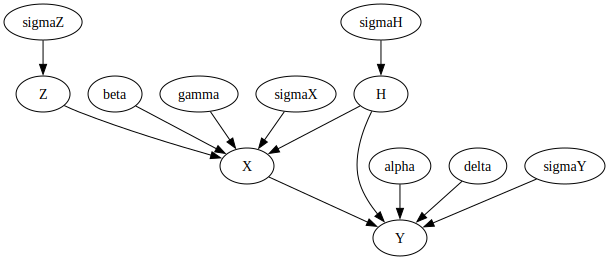

In [2]:
class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,2)

    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(0, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y

pyro.render_model(BayesianLinearGaussianSCM())


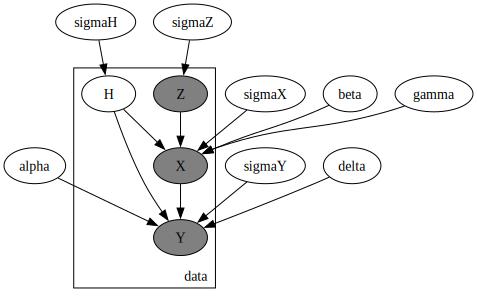

In [3]:
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self):
        super().__init__()

    def forward(self, X : torch.tensor, Y: torch.tensor,Z : torch.tensor):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", Z.shape[0], dim=-1):
                return super().forward()
            

pyro.render_model(lambda : ObservedBayesianLinearGaussianSCM()(Z=torch.rand(10), X=torch.rand(10), Y=torch.rand(10)))

### Data

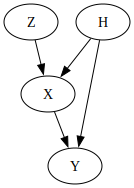

In [11]:
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(2.0), torch.tensor(-10.5)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(1.0), torch.tensor(1.8), torch.tensor(1.0), torch.tensor(1.0)
num_samples = 5000

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY)

# sample from the model
with pyro.plate('samples', num_samples):
    tr=pyro.poutine.trace(gt_model).get_trace()

x_obs,y_obs,z_obs=[tr.nodes[name]['value'] for name in ['X','Y','Z']]

pyro.render_model(gt_model)


Sanity check: the ATE on the ground truth model should give the alpha coefficient

In [39]:
num_samples = 20000
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('samples', num_samples):
    x_all,y_all = gt_model()
    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('samples', num_samples):
    x_all,y_all = gt_model()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

ate_direct=1.500065565109253
xz = 1.9909003973007202, yz = 2.986427068710327, ate_2sls = 1.5000383853912354


### Original query

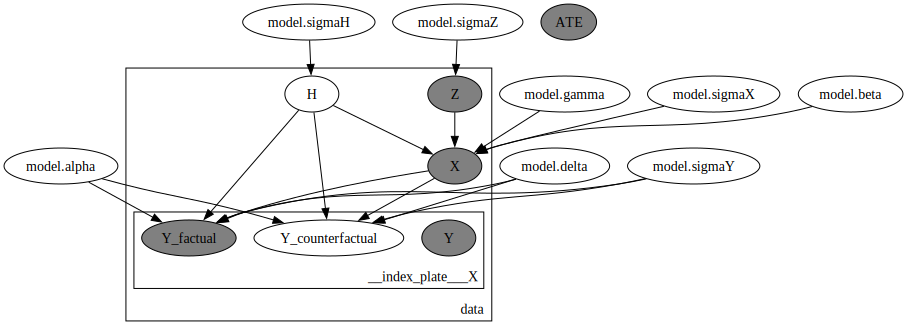

In [12]:
class LinearInstrumentalATE(PyroModule):
    def __init__(self, causal_model : Callable):
        super().__init__()
        self.model = causal_model

    def forward(self, x_obs=None, y_obs=None, z_obs=None):
        with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))):
            _, y_all = self.model(X=x_obs, Y=y_obs, Z=z_obs)
            y_cf_1 = gather(y_all, IndexSet(X={2}))
            y_cf_0 = gather(y_all, IndexSet(X={1}))
        
        ate =  (y_cf_1 - y_cf_0).mean()
        return pyro.deterministic("ATE", ate, event_dim=0)
        
pyro.render_model(lambda : LinearInstrumentalATE(ObservedBayesianLinearGaussianSCM())(z_obs=torch.rand(10), x_obs=torch.rand(10), y_obs=torch.rand(10)))

### Option 1 - inference on the original model

In [7]:
num_iterations = 5000 if not smoke_test else 10

pyro.clear_param_store()

obs_model = ObservedBayesianLinearGaussianSCM()
obs_guide = AutoNormal(obs_model)

svi = SVI(obs_model, obs_guide, pyro.optim.Adam({"lr": 0.05}), loss=Trace_ELBO())

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X=x_obs,Y=y_obs,Z=z_obs)
    if (j + 1) % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 1000] loss: 36799.7784
[iteration 2000] loss: 36603.6012
[iteration 3000] loss: 36569.4879
[iteration 4000] loss: 36497.8371
[iteration 5000] loss: 36495.0947


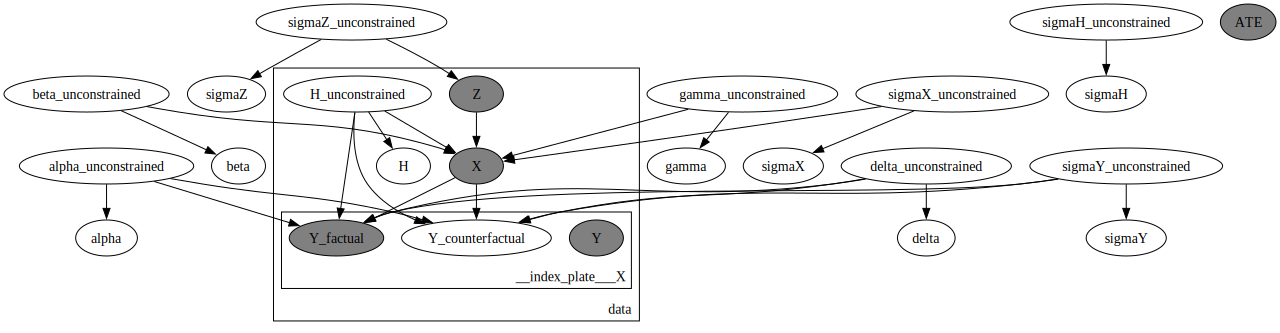

In [8]:
pyro.render_model(LinearInstrumentalATE(PredictiveModel(obs_model,obs_guide)),(x_obs,y_obs,z_obs))

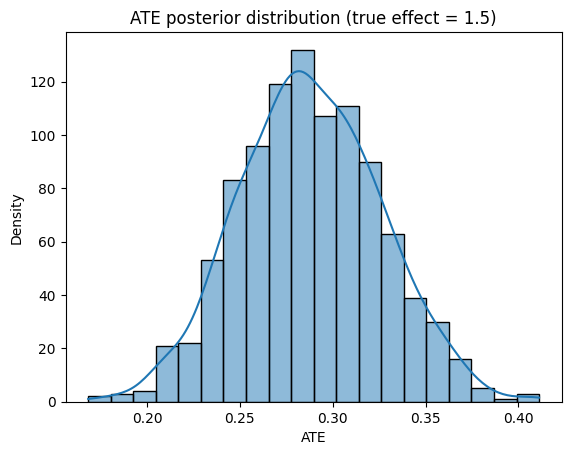

In [9]:
ates_predicted = Predictive(LinearInstrumentalATE(PredictiveModel(obs_model,obs_guide)), num_samples=1000)(x_obs,y_obs,z_obs)["ATE"].squeeze()

sns.histplot(ates_predicted, bins=20, kde=True)
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution (true effect = {true_alpha.item()})')
plt.show()

### Option 2 - inference on the counterfactual model

In [ ]:
num_iterations = 5000 if not smoke_test else 10

pyro.clear_param_store()

ate_model = LinearInstrumentalATE(ObservedBayesianLinearGaussianSCM())
ate_guide = AutoNormal(ate_model)

svi = SVI(ate_model, ate_guide, pyro.optim.Adam({"lr": 0.05}), loss=Trace_ELBO())

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_obs,y_obs,z_obs)
    if (j + 1) % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))



In [ ]:
# Make predictions
instrumental_predicted_ates = Predictive(ate_model, guide=ate_guide, num_samples=1000)(x_obs,y_obs,z_obs)["ATE"].squeeze()

# plot histogram
sns.histplot(instrumental_predicted_ates, bins=20, kde=True)
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution (true effect = {true_alpha.item()})')
plt.show()

We have a biased estimate, even though we've observed the instrument.

## Two-stage least squares : direct solution

In [ ]:
# linear regression model for Z~X, find the coefficient

beta_lsq = torch.linalg.lstsq(torch.cat((z_obs.unsqueeze(-1),torch.ones_like(z_obs).unsqueeze(-1)),dim=1), x_obs.unsqueeze(-1)).solution[0]

alpha_lsq = torch.linalg.lstsq(torch.cat((beta_lsq*z_obs.unsqueeze(-1),torch.ones_like(z_obs).unsqueeze(-1)),dim=1), y_obs.unsqueeze(-1)).solution[0]

print(f'true: {true_alpha}, estimated: {alpha_lsq}')

## The "Chirho Way"??